# Opening a fast food restaurant in Baltimore, MD

## 1. Introduction

### 1.1 Business Problem

The objective of this capstone project is to find the most suitable location for the entrepreneur to open a new fast food restaurant in Baltimore, MD. By using data science methods and unsupervised machine learning methods such as clustering, this project aims to provide solutions to answer the business question: In Baltimore, if an entrepreneur wants to open a fast food restaurant, where should he consider opening it?

### 1.2 Target Audience

The entrepreneur who wants to find the location to open a fast food restaurant in Baltimore

## 2. Data

### 2.1 Baltimore rent prices dataset

This dataset contains average rent prices for standard 1 bedroom apartment for each of 272 Baltimore neighborhoods. Unfortunately, I did not find the similar dataset for commercial real estate, however rent prices ratio among neighborhoods should be more or less similar for residential and commercial real estate. 
Rent price amount is one of the most important factors in terms of choosing the place for future restaurant. Thats why this variable will be included in the analysis

### 2.2 Baltimore crime dataset

Baltimore is very far from being a safe city. That is why this dataset will help to determine the safest neighborhoods as every entrepreneur wants to have his business located in a safe area

### 2.3 Baltimore population dataset

This dataset contains information about population of each of 272 Baltimore neighborhoods. I need this data to determine criminal level in each neighborhood, because absolute number of crimes per neighborhood does not represent safety level since in highly populated neighborhoods there is higher probability of happening more crimes. So, I will divide number of crimes by population to calculate number of crimes per person in Baltimore neighborhoods

### 2.4 Foursquare API

Foursquare API will allow to retrieve information about the number of popular spots in each neighborhood in Baltimore. This will be a good indication of foot traffic. Calling the Foursquare API returns a JSON file, which can be turned into a dataframe for analysis in python

## 3. Data Preparation

In [1]:
#First, we need to import all dependencies
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         395 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

### Crimes dataset

In [2]:
#read crimes dataset
df_crimes = pd.read_csv('https://data.baltimorecity.gov/api/views/wsfq-mvij/rows.csv?accessType=DOWNLOAD')
df_crimes.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
0,05/30/2020,18:18:00,4E,1200 MCCULLOH ST,COMMON ASSAULT,I,NaN,123,CENTRAL,UPTON,-76.627035,39.301886,NaN,ROW/TOWNHOUSE-OCC,NaN,1
1,05/30/2020,18:35:00,5A,1000 N PATTERSON PARK AVE,BURGLARY,I,NaN,322,EASTERN,MIDDLE EAST,-76.585380,39.301852,NaN,ROW/TOWNHOUSE-OCC,Eastern 2,1
2,05/30/2020,17:50:00,4E,4800 GWYNN OAK AVE,COMMON ASSAULT,I,NaN,622,NORTHWEST,HOWARD PARK,-76.697653,39.330594,NaN,ROW/TOWNHOUSE-OCC,NaN,1
3,05/30/2020,02:14:00,4E,3000 GRANTLEY AVE,COMMON ASSAULT,I,NaN,613,NORTHWEST,TOWANDA-GRANTLEY,-76.669235,39.336714,NaN,ROW/TOWNHOUSE-OCC,NaN,1
4,05/30/2020,16:20:00,6J,YORK RD & MONTPELIER ST,LARCENY,O,NaN,513,NORTHERN,NaN,-76.608855,39.326454,NaN,STREET,NaN,1


In [3]:
#we need only 2 columns
df_crimes=df_crimes[['CrimeDate','Neighborhood']]

In [4]:
print(df_crimes.dtypes)

CrimeDate       object
Neighborhood    object
dtype: object


In [5]:
#CrimeDate is an object. We need to convert it to datetime
df_crimes['CrimeDate'] = df_crimes['CrimeDate'].astype('datetime64[ns]')

In [6]:
#We need only current crime situation. Lets keep only last 3 years data
df_crimes = df_crimes.loc[df_crimes['CrimeDate'] > '2017-01-01']

In [7]:
#time to drop null values
df_crimes = df_crimes.dropna()
df_crimes.shape

(155562, 2)

In [8]:
#Lets count crimes by neighborhoods
df_crimes_grouped = df_crimes.groupby('Neighborhood',as_index = False).count()
df_crimes_grouped.head()

,Neighborhood,CrimeDate
0,4X4,318
1,ABELL,368
2,ALLENDALE,969
3,ARCADIA,161
4,ARLINGTON,692


### Population and coordinates dataset

In [9]:
df_population = pd.read_csv('https://query.data.world/s/d2f7awf7nlopf4afgl3el47ghm6dv7') #read dataset
df_population = df_population[['Name','Population','the_geom']] #we need only 3 columns
df_population['Name'] = df_population['Name'].str.upper() #make neighborhoods names uppercase to merge with crimes dataset
df_population.rename(columns={'Name': 'Neighborhood'}, inplace = True) #rename neighborhood names columm
df_population.head()

,Neighborhood,Population,the_geom
0,ABELL,889.0,MULTIPOLYGON (((-76.61113021264933 39.32343829...
1,ALLENDALE,3554.0,MULTIPOLYGON (((-76.67262514014695 39.29183630...
2,ARCADIA,1235.0,MULTIPOLYGON (((-76.56852496130239 39.33594331...
3,BOYD-BOOTH,822.0,MULTIPOLYGON (((-76.65153098537668 39.28642992...
4,ARLINGTON,2598.0,MULTIPOLYGON (((-76.68626338505344 39.34790493...


In [10]:
#time to merge two datasets
df_merged=pd.merge(df_crimes_grouped,df_population,how="outer",on="Neighborhood")
df_merged=df_merged.dropna()  #drop NA values
df_merged.head()

,Neighborhood,CrimeDate,Population,the_geom
1,ABELL,368.0,889.0,MULTIPOLYGON (((-76.61113021264933 39.32343829...
2,ALLENDALE,969.0,3554.0,MULTIPOLYGON (((-76.67262514014695 39.29183630...
3,ARCADIA,161.0,1235.0,MULTIPOLYGON (((-76.56852496130239 39.33594331...
4,ARLINGTON,692.0,2598.0,MULTIPOLYGON (((-76.68626338505344 39.34790493...
5,ARMISTEAD GARDENS,582.0,3458.0,MULTIPOLYGON (((-76.55879992777896 39.30645665...


### Cleaning and preparing merged dataset

In [11]:
df_merged = df_merged[(df_merged != 0).all(1)] #drop zero values
df_merged = df_merged[df_merged['Population'] > 499] #we are not interested in neighborhoods with less than 500 tenants
#Crimes per population shows safety level of a neighborhood better than just number of crimes 
df_merged['Crimes per 1 person'] = df_merged['CrimeDate'] / df_merged['Population']
df_merged = df_merged.sort_values(by= ['Crimes per 1 person'], ascending = False)
df_merged.rename(columns={'the_geom': 'Coordinates'}, inplace = True)
#Making new columns Latitude and Longitude out of initial coordinates column
df_merged['Coordinates'] = df_merged['Coordinates'].map(lambda x: x.lstrip('MULTIPOLYGON ((('))
df_merged['Coordinates'] = df_merged['Coordinates'].str[:35]
df_merged[['Longitude','Latitude']] = df_merged['Coordinates'].str.split(' ', expand=True)

In [12]:
#drop unneeded columns
df_merged = df_merged[['Neighborhood','Population','Crimes per 1 person','Latitude','Longitude']]
df_merged.head()

,Neighborhood,Population,Crimes per 1 person,Latitude,Longitude
122,INNER HARBOR,1484.0,1.580863,39.2843612174191,-76.61332268206179
66,DOWNTOWN,4448.0,1.218525,39.2894922456335,-76.60549025746245
157,MIDDLE EAST,1484.0,1.042453,39.29872242913879,-76.5851275142668
45,CHARLES NORTH,1059.0,0.891407,39.3142726593081,-76.61571455479564
207,REISTERSTOWN STATION,1968.0,0.634654,39.3512380859961,-76.70885511420639


### Baltimore rent prices dataset

In [13]:
df_rent = pd.read_excel("Rent Prices.xlsx") #read Baltimore rent prices dataset
df_rent.head()

,Neighborhood,price
0,Abell,1445
1,Allendale,956
2,Arcadia,916
3,Arlington,1001
4,Armistead Gardens,1428


In [14]:
#small dataset preparations before merging
df_rent['price'] = df_rent['price'].astype('int') 
df_rent['Neighborhood'] = df_rent['Neighborhood'].str.upper()
df_rent.rename(columns={'price': 'Rent Price'}, inplace = True)
df_rent.head()

,Neighborhood,Rent Price
0,ABELL,1445
1,ALLENDALE,956
2,ARCADIA,916
3,ARLINGTON,1001
4,ARMISTEAD GARDENS,1428


In [15]:
#Adding Baltimore rent prices dataset to the main dataset
df_supermerged=pd.merge(df_merged,df_rent,how="outer",on="Neighborhood")
df_supermerged['Latitude'] = df_supermerged['Latitude'].str[:14]
df_supermerged = df_supermerged.dropna()

In [16]:
#Changing coordinate columns type from string to float
df_supermerged['Latitude'] = df_supermerged['Latitude'].astype(float)
df_supermerged['Longitude'] = df_supermerged['Longitude'].astype(float)
df_supermerged.head()

,Neighborhood,Population,Crimes per 1 person,Latitude,Longitude,Rent Price
0,INNER HARBOR,1484.0,1.580863,39.284361,-76.613323,1792.0
1,DOWNTOWN,4448.0,1.218525,39.289492,-76.605490,1582.0
2,MIDDLE EAST,1484.0,1.042453,39.298722,-76.585128,1408.0
3,CHARLES NORTH,1059.0,0.891407,39.314273,-76.615715,1551.0
4,REISTERSTOWN STATION,1968.0,0.634654,39.351238,-76.708855,1001.0


## 4. Methodology / Modelling

My initial plan was to 1. Use Foursquare API to get the information about number of venues per neighborhood 2. Use k-means clustering to cluster neighborhoods in purpose to get cluster with low rent prices and crimes per person and high number of venues, that is evidence of high foot traffic of neighborhood.

Unfortunately, Foursquare API doesnt work properly and is not able to get data for almost 200 neighborhoods without errors. Thats why I decided 1.to cluster my current dataset to choose the most suitable cluster 2. Use Foursquare API for chosen cluster only 3. Finally, select from this cluster a few neighborhoods with a lot of venues around

So, its time for K-means clustering. However, firstly we need to normalize values and define the right K - number of clusters

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [18]:
#Using MinMaxScaler to normalize values in different columns
df_clustering = df_supermerged.drop(['Neighborhood','Latitude','Longitude'], 1)
mms = MinMaxScaler()
mms.fit(df_clustering)
data_transformed = mms.transform(df_clustering)

In [19]:
#Defining the right value for K - number of clusters. We are using Elbow Method
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

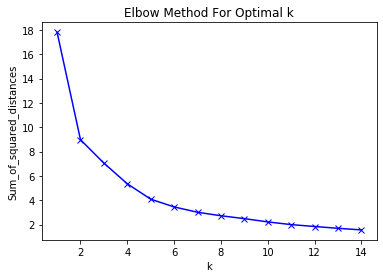

In [20]:
#PLot elbow method graph
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [21]:
# Elbow method suggests to use 2 clusters, but im afraid that Foursquare API will not be able to work with such big clusters. So, lets set K=3
kclusters = 3

In [22]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_transformed)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 1, 1, 2, 1, 2, 2], dtype=int32)

In [23]:
df_supermerged.insert(0, 'Cluster Labels', kmeans.labels_)
df_supermerged.head()

,Cluster Labels,Neighborhood,Population,Crimes per 1 person,Latitude,Longitude,Rent Price
0,2,INNER HARBOR,1484.0,1.580863,39.284361,-76.613323,1792.0
1,2,DOWNTOWN,4448.0,1.218525,39.289492,-76.605490,1582.0
2,2,MIDDLE EAST,1484.0,1.042453,39.298722,-76.585128,1408.0
3,2,CHARLES NORTH,1059.0,0.891407,39.314273,-76.615715,1551.0
4,1,REISTERSTOWN STATION,1968.0,0.634654,39.351238,-76.708855,1001.0


#### Mapping clusters

In [24]:
#First we need to get Baltimore coordinates
address = 'Baltimore, MD'

geolocator = Nominatim(user_agent="baltimore_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Baltimore  are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_supermerged['Latitude'], df_supermerged['Longitude'], df_supermerged['Neighborhood'], df_supermerged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Baltimore  are 39.2908816, -76.610759.


In [25]:
#Making the datasets of each cluster
cluster_0 = df_supermerged.loc[df_supermerged['Cluster Labels'] == 0, df_supermerged.columns[[1,2,3,4,5] + list(range(6, df_supermerged.shape[1]))]]
cluster_1 = df_supermerged.loc[df_supermerged['Cluster Labels'] == 1, df_supermerged.columns[[1,2,3,4,5] + list(range(6, df_supermerged.shape[1]))]]
cluster_2 = df_supermerged.loc[df_supermerged['Cluster Labels'] == 2, df_supermerged.columns[[1,2,3,4,5] + list(range(6, df_supermerged.shape[1]))]]

In [26]:
cluster_0.describe()
# big population, low criminal level, low rent price. Just what we need!

,Population,Crimes per 1 person,Latitude,Longitude,Rent Price
count,22.000000,22.000000,22.000000,22.000000,22.000000
mean,7790.909091,0.183235,39.328702,-76.625446,1209.000000
std,3581.558864,0.084477,0.035886,0.055042,215.651836
min,4219.000000,0.048281,39.234504,-76.709871,860.000000
25%,5471.500000,0.121359,39.311495,-76.664780,1080.000000
50%,6563.000000,0.200475,39.335068,-76.626312,1228.000000
75%,8492.250000,0.233515,39.355447,-76.589351,1303.500000
max,17694.000000,0.339715,39.371964,-76.529975,1720.000000


In [27]:
cluster_1.describe()
# Small population, low criminal level, very low rent price. 
# Looks like this cluster is suburbs, map proves it. Definetely, not the best neighborhoods to open restaurant

,Population,Crimes per 1 person,Latitude,Longitude,Rent Price
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1957.826457,0.220191,39.322920,-76.642646,1042.110000
std,1041.812374,0.110125,0.029341,0.048646,115.289963
min,562.325500,0.021340,39.223828,-76.711206,850.000000
25%,1171.000000,0.147955,39.300160,-76.680856,956.000000
50%,1783.500000,0.202491,39.325201,-76.658645,1001.000000
75%,2617.500000,0.271709,39.347583,-76.607069,1080.000000
max,4974.000000,0.634654,39.372000,-76.529691,1325.000000


In [28]:
cluster_2.describe()
# Small population, relatively high criminal level, high rent price.
# The worst choice in terms of opening a restaurant

,Population,Crimes per 1 person,Latitude,Longitude,Rent Price
count,55.000000,55.000000,55.000000,55.000000,55.000000
mean,2188.654545,0.333739,39.302328,-76.603164,1629.290909
std,1286.399069,0.281875,0.025130,0.026491,207.716480
min,576.000000,0.033695,39.253584,-76.655543,1359.000000
25%,1245.000000,0.170480,39.286935,-76.619326,1445.000000
50%,1823.000000,0.273752,39.297023,-76.609417,1582.000000
75%,2989.500000,0.412277,39.318855,-76.589541,1738.000000
max,5671.000000,1.580863,39.371998,-76.529808,2063.000000


### Foursquare API to understand foot traffic in the neighborhoods

In [29]:
#Define foursquare credentials and version
CLIENT_ID = 'MTBEPPARHYK0B1AEQOHT3LM1PCQK2TATB430OZZ5502NZ3YH' # my Foursquare ID
CLIENT_SECRET = 'Q1ASXW0QJYGAFL230KLUZFM4EJTIVCV4JYVEEY0DGOZA3R5H' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [30]:
#let's get for all neighborhoods the top 100 venues within a radius of 500 meters.¶
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
limit=100

In [31]:
#getting list of venues for each neighborhood
baltimore_venues = getNearbyVenues(names=cluster_0['Neighborhood'],
                                   latitudes=cluster_0['Latitude'],
                                   longitudes=cluster_0['Longitude'])

UPTON
BROOKLYN
BROADWAY EAST
SANDTOWN-WINCHESTER
CHERRY HILL
CENTRAL PARK HEIGHTS
FRANKFORD
RESERVOIR HILL
BELAIR-EDISON
HAMPDEN
CANTON
CHARLES VILLAGE
HOWARD PARK
NEW NORTHWOOD
WALTHERSON
LOCH RAVEN
GLEN
FALLSTAFF
ROLAND PARK
NORTH HARFORD ROAD
CROSS COUNTRY
CHESWOLDE


In [32]:
print(baltimore_venues.shape)
baltimore_venues.head()

(234, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,UPTON,39.300173,-76.624831,Land of Kush,39.300180,-76.621671,Vegetarian / Vegan Restaurant
1,UPTON,39.300173,-76.624831,Eubie Blake National Jazz Institute And Cultur...,39.299596,-76.619939,History Museum
2,UPTON,39.300173,-76.624831,The Bun Shop,39.300658,-76.619488,Bakery
3,UPTON,39.300173,-76.624831,Linden Deli,39.301302,-76.620002,Deli / Bodega
4,UPTON,39.300173,-76.624831,Hip Hop Fish & Chicken,39.300345,-76.621890,Fish & Chips Shop


In [33]:
#Choosing neighborhoods with a lot of venues
baltimore_venues.groupby('Neighborhood').count()
df = baltimore_venues.groupby('Neighborhood').filter(lambda x : len(x)>20)
df.iloc[:, 0]

Neighborhood
CANTON             34
CHARLES VILLAGE    30
GLEN               30
HAMPDEN            30
Name: Neighborhood Latitude, dtype: int64

In [34]:
#Selected_Neighborhoods is a final dataset.
#It shows the best neighborhoods to open restaurant
Selected_Neighborhoods = cluster_0.loc[(cluster_0['Neighborhood']=='CANTON') | (cluster_0['Neighborhood']=='CHARLES VILLAGE') | (cluster_0['Neighborhood']=='GLEN') | (cluster_0['Neighborhood']=='HAMPDEN')]
Selected_Neighborhoods

,Neighborhood,Population,Crimes per 1 person,Latitude,Longitude,Rent Price
99,HAMPDEN,6963.0,0.202786,39.327068,-76.627793,1306.0
102,CANTON,12192.0,0.201198,39.286136,-76.580042,1720.0
104,CHARLES VILLAGE,8906.0,0.199753,39.317899,-76.615389,1445.0
155,GLEN,7876.0,0.120112,39.356230,-76.702458,1001.0


## Results

I have pulled data on population, rent prices and crime rates for every neighborhood in Baltimore and used this information to narrow down our neighborhood options to 1 cluster of 22 neighborhoods. Then I used Foursquare API for these 22 neighborhoods and retrieved number of popular venues in every neighborhood. It allowed me to select 4 neighborhoods with the highest foot traffic.

In [47]:
map_baltimore = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(Selected_Neighborhoods['Latitude'], Selected_Neighborhoods['Longitude'], Selected_Neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_baltimore)  
    
map_baltimore

In [48]:
df = df.reset_index()
df = df[['Neighborhood','Venue']]
Results = pd.merge(Selected_Neighborhoods,df,how="outer",on="Neighborhood")
Results = Results[['Neighborhood','Population','Crimes per 1 person','Rent Price','Venue']]
Results.rename(columns={'Venue': 'Venues'}, inplace = True)
Results

,Neighborhood,Population,Crimes per 1 person,Rent Price,Venues
0,HAMPDEN,6963.0,0.202786,1306.0,30
1,CANTON,12192.0,0.201198,1720.0,34
2,CHARLES VILLAGE,8906.0,0.199753,1445.0,30
3,GLEN,7876.0,0.120112,1001.0,30


Let's now analyze 4 retrieved neighborhoods: Hampden, Canton, Charles Village and Glen. First of all, each neighborhood is densely populated and safe compared to other Baltimore neighborhoods (average Baltimore neighborhood population - 2755, average crimes per person - 0,25). In terms of foot traffic these 4 neighborhoods are also one of the best (only 17 out of 270 have more than 34 popular venues). Rent prices significantly differs between 4 neighborhoods (from 1001 to 1720. Anyway its much lower than maximum of 2063). 
So, I can conclude that <b>each of 4 selected neighborhoods could be a very good location to open a restaurant</b>. 

<b>GLEN</b>  Extremely low rent price and safety level, but located in Baltimore suburbs. Perfect place to open cheap fast food restaurant with small budget.

<b>HAMPDEN and CHARLES VILLAGE</b>  Good safety level and medium rent prices. Located relatively close to city center. Very well-balanced choices in terms of opening a fast food restaurant.

<b>CANTON</b> The most populated neighborhood and located in the city center near the biggest city park! It's fair that rent price is higher than average. Canton is a perfect location to open a restaurant, if an entrepreneur can afford a rent

Ultimately, the optimal spot depends on what type of restaurant you would like to open.


## Discussion

A major drawback of this analysis is that the clustering was completely based on Foursquare’ s data for popular venues. There are plenty other ways to assess popularity of neighborhoods and the spots inside them, venue popularity is just one of them. It may also be helpful to look exclusively at cafes and restaurants in an area, how many there are, and how popular they are on weekdays and weekends.



## Conclusion

Finally, we have executed an end-to-end data science project using common python libraries to manipulate datasets, Foursquare API to explore the neighborhoods of Baltimore, Folium leaflet map and unsupervised machine learning algorithm K-means with elbow method to cluster and segment neighborhoods. Thanks for reading!